In [1]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import h5py
import os.path


import torch.nn.functional as F
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


# Length based data

In [3]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
inputX_raw = np.load(INPUT_X)[:,0:n_data]
inputY_raw = np.load(INPUT_Y)[:,0:n_data]
inputPara_raw = np.load(INPUT_para)[:,0:n_data]
output_raw = np.load(OUTPUT)[:,0:n_data]

N_s, L_x = 2001, 500


Text(0, 0.5, 'L_p')

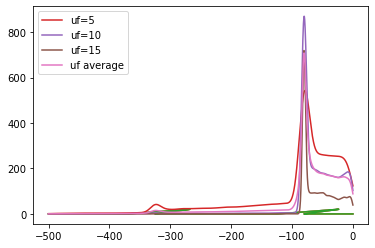

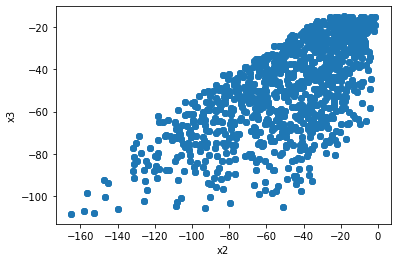

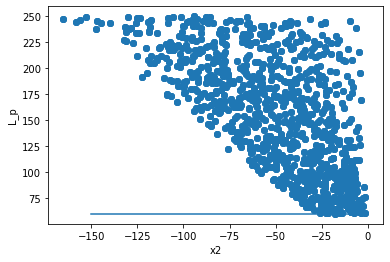

In [4]:
# Combine data
plt.figure()
test_id = 0
plt.plot(inputX_raw[:,3*test_id], inputY_raw[:,3*test_id])
plt.plot(inputX_raw[:,3*test_id+1], inputY_raw[:,3*test_id+1])
plt.plot(inputX_raw[:,3*test_id+2], inputY_raw[:,3*test_id+2])
sample, uf, L_p, x1, x2, x3, h = inputPara_raw[:,3*test_id]

xx = np.linspace(-L_x, 0, N_s)
plt.plot(xx, output_raw[:,3*test_id], label="uf=5")
plt.plot(xx, output_raw[:,3*test_id+1], label="uf=10")
plt.plot(xx, output_raw[:,3*test_id+2], label="uf=15")
plt.plot(xx, (output_raw[:,3*test_id]+output_raw[:,3*test_id+1]+output_raw[:,3*test_id+2])/3, label="uf average")
plt.legend()

plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[5,:])
plt.xlabel("x2")
plt.ylabel("x3")

plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[2,:])
plt.plot(np.linspace(-150,0,100), np.linspace(60,60,100))
plt.xlabel("x2")
plt.ylabel("L_p")


In [7]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


ntrain = 900
ntest = 100

batch_size = 20
learning_rate = 0.001
epochs = 1001
step_size = 100
gamma = 0.5

n_periods = 10
# modes = n_periods*16
# width = n_periods*32

modes = 64
width = 64
# nx ny
s = N_s

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0




print("inputX.shape", inputX.shape)
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
print("input shape: n_data, n_p, n_features = ", input.shape)
output = torch.tensor(output, dtype=torch.float).permute(1,0)
print("output shape: n_data, n_p, n_features = ", output.shape)

index = torch.randperm(ntrain+ntest)
train_index = index[:ntrain]
test_index = index[-ntest:]

x_train = input[train_index]
y_train = output[train_index]
x_test = input[test_index]
y_test = output[test_index]
x_train = x_train.reshape(ntrain, s, 2)
x_test = x_test.reshape(ntest, s, 2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size,
                                          shuffle=False)
test_loader2 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1,
                                          shuffle=False)

if __name__ == "__main__":
    ################################################################
    # training and evaluation
    ################################################################
    
    padding=100
    input_channel=2
    output_np=s

    model = FNO1d(modes, width, padding=padding, input_channel=input_channel, output_np=output_np).cuda()
    print(count_params(model))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = LpLoss(size_average=False)

    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            out =  torch.exp(model(x))

            loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()

        scheduler.step()

        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

#                 out =  model(x)
                out =  torch.exp(model(x))
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        train_l2 /= ntrain
        test_l2 /= ntest

        t2 = default_timer()
        print(ep, t2 - t1, train_l2, test_l2)

        # plot
        if ep%step_size==0:
            torch.save(model, 'catheter_plain_length_model_1d'+str(ep))



inputX.shape (2001, 1000)
input shape: n_data, n_p, n_features =  torch.Size([1000, 2001, 2])
output shape: n_data, n_p, n_features =  torch.Size([1000, 2001])
1336001
0 1.1980017870664597 1.4775255743662516 0.9158145904541015
1 1.1983323395252228 0.6797601445515951 0.6232885074615478
2 1.1847946308553219 0.617229101392958 0.6139479827880859
3 1.1769332457333803 0.6043006695641412 0.6194897937774658
4 1.1767675057053566 0.5939575746324327 0.6084622192382813
5 1.1766699273139238 0.5754040421379937 0.5942891883850098
6 1.1770021189004183 0.5508949406941732 0.5108007431030274
7 1.1814083456993103 0.48456558651394316 0.453814115524292
8 1.1762541458010674 0.4470128552118937 0.48890315055847167
9 1.1770600210875273 0.4496652444203695 0.4940462112426758
10 1.1762914545834064 0.3980866691801283 0.43065685749053956
11 1.176361283287406 0.37126351833343507 0.36733081340789797
12 1.1778143383562565 0.3814376825756497 0.37032339096069333
13 1.1767237484455109 0.3351995457543267 0.3747771596908569

KeyboardInterrupt: 

In [11]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


# zero tests 

ntrain = 1000

batch_size = 20
learning_rate = 0.001
epochs = 1001
step_size = 100
gamma = 0.5

n_periods = 10
# modes = n_periods*16
# width = n_periods*32
modes = 64
width = 64

# nx ny
s = N_s

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0




print("inputX.shape", inputX.shape)
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
print("input shape: n_data, n_p, n_features = ", input.shape)
output = torch.tensor(output, dtype=torch.float).permute(1,0)
print("output shape: n_data, n_p, n_features = ", output.shape)

index = torch.randperm(ntrain)
train_index = index[:ntrain]

x_train = input[train_index]
y_train = output[train_index]
x_train = x_train.reshape(ntrain, s, 2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,
                                           shuffle=True)                                 

if __name__ == "__main__":
    ################################################################
    # training and evaluation
    ################################################################
    
    padding=100
    input_channel=2
    output_np=s

    model = FNO1d(modes, width, padding=padding, input_channel=input_channel, output_np=output_np).cuda()
    print(count_params(model))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = LpLoss(size_average=False)

    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            out = torch.exp(model(x))

            loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()

        scheduler.step()

        model.eval()
        
        train_l2 /= ntrain

        t2 = default_timer()
        print(ep, t2 - t1, train_l2)

        # plot
        if ep%step_size==0:
            torch.save(model, 'catheter_plain_length_model_1d'+str(ep))



inputX.shape (2001, 1000)
input shape: n_data, n_p, n_features =  torch.Size([1000, 2001, 2])
output shape: n_data, n_p, n_features =  torch.Size([1000, 2001])
1336001
0 1.2769754864275455 1.2290015068054199
1 1.2655905056744814 0.6109203424453735
2 1.2612695842981339 0.6335897636413574
3 1.2621550243347883 0.6006281175613404
4 1.2618746049702168 0.5626185836791993
5 1.2621403746306896 0.5222607107162476
6 1.2730219271034002 0.49057582950592044
7 1.262554807588458 0.42441271018981935
8 1.2626233249902725 0.36574988794326785
9 1.2617833483964205 0.35868933868408204
10 1.2624409943819046 0.36820928382873536
11 1.2618954088538885 0.35663035821914674
12 1.2736786678433418 0.31883122253417967
13 1.2735883630812168 0.2948878765106201
14 1.2730233445763588 0.30287085962295535
15 1.262947954237461 0.2839982061386108
16 1.2616079077124596 0.2614908685684204
17 1.2620172575116158 0.2563236536979675
18 1.2622302528470755 0.2543627030849457
19 1.2621667888015509 0.22525755524635316
20 1.2623597979